### Loading initial libraries

In [19]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import initializers
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 14, 8

data_path='../data/KAGGLE_DS/kaggle_creditcard.csv'

### Reading, transforming and separating the dataset into training and testing sets

In [20]:
    data=pd.read_csv(data_path)
    data=data.rename(columns={'Class': 'Fraud'})

    #Create a new feature for normal (non-fraudulent) transactions.
    data.loc[data.Fraud == 0, 'Normal'] = 1
    data.loc[data.Fraud == 1, 'Normal'] = 0

    # Separating the fraud and normal datasets
    fraud  = data[data.Fraud == 1]
    normal = data[data.Fraud == 0]

    # Setting up the training dataset
    train_frac = 0.8
    X_train = fraud.sample(frac=train_frac)
    count_Frauds = len(X_train)
    X_train = X_train.append(normal.sample(frac=train_frac))

    # Setting up the testing dataset
    X_test = data.loc[~data.index.isin(X_train.index)]

    # Shuffling the data so that the training happens in a random order
    random_state=22
    X_train = shuffle(X_train, random_state=random_state)
    X_test = shuffle(X_test, random_state=random_state)

    # Adding out target values to y_train and y_test
    y_train = pd.concat([X_train.pop('Normal'), X_train.pop('Fraud')], axis=1)
    y_test = pd.concat([X_test.pop('Normal'), X_test.pop('Fraud')], axis=1)

In [21]:
X_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,...,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000
mean,94825.432116,-0.000627,-0.000259,0.000950,-0.003174,0.000023,-0.000963,-0.000019,-0.000285,0.000158,...,0.000766,-0.000072,0.000665,-0.000787,-0.000502,-0.000062,-0.000428,0.000399,-0.000479,88.221875
std,47461.619161,1.962226,1.660638,1.516796,1.415601,1.386726,1.334144,1.245799,1.196650,1.099858,...,0.776570,0.731482,0.724995,0.616031,0.606480,0.521024,0.481904,0.404577,0.329122,252.581718
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,54247.000000,-0.921195,-0.600653,-0.887791,-0.851508,-0.692616,-0.769129,-0.554277,-0.208426,-0.642554,...,-0.211977,-0.228045,-0.540604,-0.162430,-0.355405,-0.316851,-0.327026,-0.070780,-0.053108,5.550000
50%,84711.000000,0.016925,0.066304,0.180618,-0.022813,-0.054212,-0.274978,0.040497,0.022426,-0.052565,...,-0.062613,-0.029164,0.006529,-0.011292,0.040951,0.016943,-0.053430,0.001296,0.011289,21.990000
75%,139309.000000,1.315340,0.804240,1.028314,0.740673,0.612640,0.397865,0.569545,0.326785,0.596306,...,0.133735,0.186915,0.528737,0.147157,0.439262,0.351058,0.240531,0.091360,0.078293,77.000000
max,172788.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,39.420904,27.202839,10.503090,22.528412,4.584549,5.826159,3.463246,31.612198,33.847808,25691.160000


### Normalizing the features that arent already close to 0 because DP benifites from it

In [22]:
# The dataset needs to be balanced. 
# ratio = len(X_train)/count_Frauds 

#Transform each feature in features so that it has a mean of 0 and standard deviation of 1; 
#this helps with training the neural network.
for feature in ['Time', 'Amount']:
    mean, std = data[feature].mean(), data[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std


### Storing the data as numpy matrices, and separating the test dataset into validation and testing sets

In [23]:
# Train the neural Network. Split the testing data into validation and testing sets
split = int(len(y_test)/2)

inputX = X_train.values
inputY = y_train.values
inputX_valid = X_test.values[:split]
inputY_valid = y_test.values[:split]
inputX_test = X_test.values[split:]
inputY_test = y_test.values[split:]

### Defining the layers of the model and the number of nodes in each layer 

In [24]:
# Number of input nodes.
input_nodes = X_train.shape[1]

# Number of nodes in each hidden layer
hidden_nodes1 = 20
hidden_nodes2 = 20
hidden_nodes3 = 20
# hidden_nodes4 = 20

# input
x = keras.Input(shape=input_nodes)
y1 = layers.Dense(
    hidden_nodes1, 
    name='layer_1',
    activation = activations.sigmoid, 
    kernel_initializer = initializers.RandomNormal(stddev=0.01), 
    bias_initializer = initializers.Zeros())
y2 = layers.Dense(
    hidden_nodes2,
    name='layer_2',
    activation = activations.sigmoid, 
    kernel_initializer = initializers.RandomNormal(stddev=0.01), 
    bias_initializer = initializers.Zeros())
y3 = layers.Dense(
    hidden_nodes3, 
    name='layer_3',
   activation = activations.sigmoid, 
   kernel_initializer = initializers.RandomNormal(stddev=0.01), 
   bias_initializer = initializers.Zeros())
y5 = layers.Dense(
    2, 
    name="OUTPUT",
    activation = activations.softmax, 
    kernel_initializer = initializers.RandomNormal(stddev=0.01), 
    bias_initializer = initializers.Zeros())

# output
y = y5

### Creating the model and compiling it with the appropriate loss function and optimizer

In [25]:
model = keras.Sequential([x, y1, y2, y3, y])

# Parameters
training_epochs = 100
n_samples = y_train.shape[0]
batch_size = 1024
learning_rate = 0.05

model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy", "Recall"] #keras.metrics.Recall() ]#,  tf.keras.metrics.FalseNegatives()]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 20)                620       
_________________________________________________________________
layer_2 (Dense)              (None, 20)                420       
_________________________________________________________________
layer_3 (Dense)              (None, 20)                420       
_________________________________________________________________
OUTPUT (Dense)               (None, 2)                 42        
Total params: 1,502
Trainable params: 1,502
Non-trainable params: 0
_________________________________________________________________


### Fiting the model to the dataset

In [26]:
training_history = model.fit(
    inputX, inputY, 
    batch_size=batch_size, 
    epochs=training_epochs, 
    verbose=0, 
    use_multiprocessing=False, 
    validation_data=(inputX_valid, inputY_valid)).history

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])


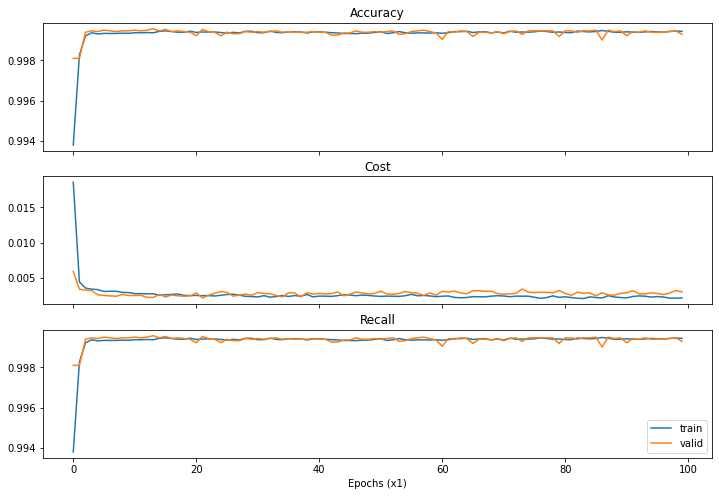

In [27]:
display_step = 1 # 10 
print(training_history.keys())

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,8))

ax1.plot(training_history['accuracy'][::display_step], label='train') # blue
ax1.plot(training_history['val_accuracy'][::display_step], label='valid') # green
ax1.set_title('Accuracy')

ax2.plot(training_history['loss'][::display_step], label='train') # blue
ax2.plot(training_history['val_loss'][::display_step], label='valid') # green
ax2.set_title('Cost')

ax3.plot(training_history['recall'][::display_step], label='train') # blue
ax3.plot(training_history['val_recall'][::display_step], label='valid') # green
ax3.set_title('Recall')

plt.xlabel('Epochs (x{})'.format(display_step))
plt.legend() 
plt.show()

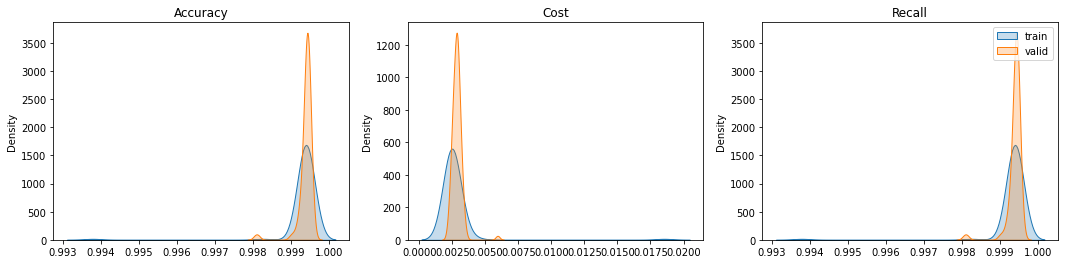

In [28]:
display_step = 1 # 10 

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4)) 

sns.kdeplot(ax=ax1, x=training_history['accuracy'][::display_step], fill=True, label='train')
sns.kdeplot(ax=ax1, x=training_history['val_accuracy'][::display_step], fill=True, label='valid')
ax1.set_title('Accuracy')

sns.kdeplot(ax=ax2, x=training_history['loss'][::display_step], fill=True, label='train')
sns.kdeplot(ax=ax2, x=training_history['val_loss'][::display_step], fill=True, label='valid')
ax2.set_title('Cost')

sns.kdeplot(ax=ax3, x=training_history['recall'][::display_step], fill=True, label='train')
sns.kdeplot(ax=ax3, x=training_history['val_recall'][::display_step], fill=True, label='valid')
ax3.set_title('Recall')



# plt.xlabel('Epochs (x{})'.format(display_step))
plt.legend() 

### Plotting the confusion matrix

Test accuracy: 99.92978%
Recall: 81.81818%


array([[28425,    12],
       [    8,    36]])

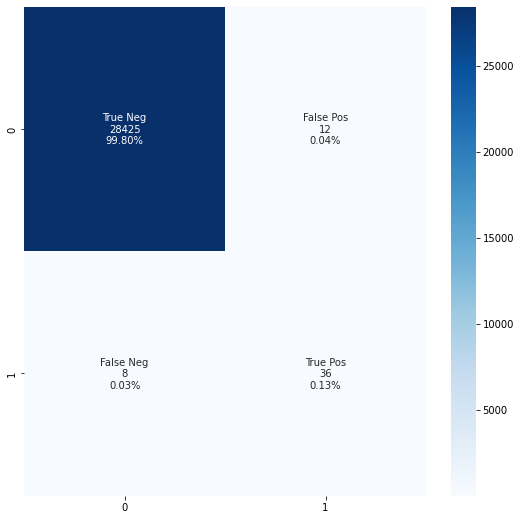

In [30]:
y_pred = model.predict(inputX_test)
y_fraud_pred = np.argmax(y_pred, 1)
y_fraud_true = np.argmax(inputY_test, 1)

plt.figure(figsize=(9, 9))

cm = confusion_matrix(y_true=y_fraud_true, y_pred=y_fraud_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
print('Test accuracy: {:.5f}%'.format(
    100 * float(cm[0][0]+cm[1][1]) / np.sum(cm)) )
print('Recall: {:.5f}%'.format(
    100 * float(cm[1][1]) / sum(cm[1])) )
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
cm

In [31]:
model.save('./BEST_2')

2021-11-24 02:38:18.126889: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./BEST_2/assets


In [ ]:
import json
url="http://localhost:8501/v1/models/fraud_detector:predict"

def make_prediction(instances):
   data = json.dumps({"signature_name": "serving_default", "instances": instances.tolist()})
   headers = {"content-type": "application/json"}
   json_response = requests.post(url, data=data, headers=headers)
   # return json_response
   predictions = json.loads(json_response.text)#['predictions']
   return predictions

make_prediction(X_test.values)